# Toy hierarchical model

In [18]:
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import distrax as dx

from coinem.model import AbstractModel

## Model

We consider generating data $y$ from a hierarchical Gaussian model with real-valued hyperparameter $\theta = 1$:

$$ p_\theta(x, y) = \mathcal{N}(y; x, I_{D_y}) \mathcal{N}(x; \theta I_{D_y}, I_{D_y}) $$

### Model in code:
To create our model we just inherit from the provided `AbstractModel`.

In [19]:
@dataclass
class HierarchicalModel(AbstractModel):
    """Base class for p(θ, x)."""
    y: Float[Array, "Ny Dy"] # Observations
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"]) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        Dy = self.y.shape[-1]
        log_prob_y_given_x = dx.MultivariateNormalDiag(jnp.atleast_1d(latent.squeeze())).log_prob(self.y) # \mathcal{N}(y; x, I_{D_y}) 
        log_prob_x_given_theta = dx.MultivariateNormalDiag(jnp.ones(Dy)*theta).log_prob(jnp.atleast_1d(latent.squeeze())) # \mathcal{N}(x; \theta I_{D_y}, I_{D_y})

        # Compute log-probability.
        return (log_prob_y_given_x + log_prob_x_given_theta).squeeze() # log p(y|x) + log p(x|theta)

### Dataset:
We draw one observation $y$ from the model.

In [20]:
Ny = 1
Dy = 100
key = jr.PRNGKey(42)
theta = jnp.array([1.0])

key_y, key_latent = jr.split(key)
latent = theta + jr.normal(key_latent, (1, Dy))
y = jr.normal(key_y, (Ny, Dy)) + latent

### Unit tests:
We test the score of the latent function and average log-probability of the model.

In [21]:
# Define the model:
model = HierarchicalModel(y=y)

# Unit tests:
assert jnp.allclose(model.score_latent(latent, theta), (y + theta - 2.0* latent)) # Gradient of log p(y|x) wrt x
assert jnp.allclose(model.score_theta(latent, theta), Dy * (latent.mean() - theta)) # Gradient of log p(y|x) wrt theta

# Experiments

## Figure 1a

We examine the impact that different step-sizes have on PGD's stability:

(0.0, 100.0)

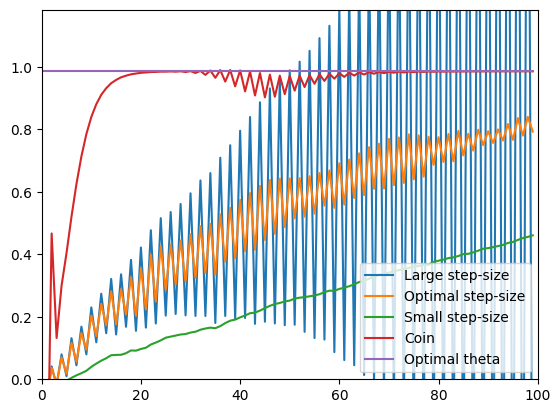

In [22]:
from coinem.zoo import pgd, coin_svgd, adam_svgd, mean_coin_svgd, coin_svgd_em, coin_svgd_me

#Set approximation parameters:

key = jr.PRNGKey(42)
K = 100  # Number of steps.
N = 10  # Number of particles.

th0 = jnp.array([0.0])  # Initial parameter guess.
X0 = jr.normal(key, (N, Dy))  # Initial particle cloud.  -NOTE: I've changed this from np.zeros because the X's in SVGD have to be different for the kernel computation

model = HierarchicalModel(y=y)

# Run PGD using three different step-sizes:
_, th_large = pgd(model, X0, th0, K, 2.05/(2+Dy))  # Large step-size
_, th_optimal = pgd(model, X0, th0, K, 2/(2+Dy))  # Optimal step-size
_, th_small = pgd(model, X0, th0, K, 0.75/(2+Dy))  # Small step-size

# Run coin_svgd:
_, th_coin = coin_svgd(model, X0, th0, K)  # coin_svgd

# Plot parameter estimates as a function of step number k:
plt.plot(th_large, label='Large step-size')
plt.plot(th_optimal, label='Optimal step-size')
plt.plot(th_small, label='Small step-size')
plt.plot(th_coin, label='Coin')
plt.plot(y.mean()*jnp.ones(K), label='Optimal theta')
plt.legend(loc='lower right')
plt.ylim([0, 1.2*y.mean()])
plt.xlim([0, K])

## Figure 1b,c

We compare the performance of PGD, PQN, PMGD, and EM:

(-10.0, 1000.0)

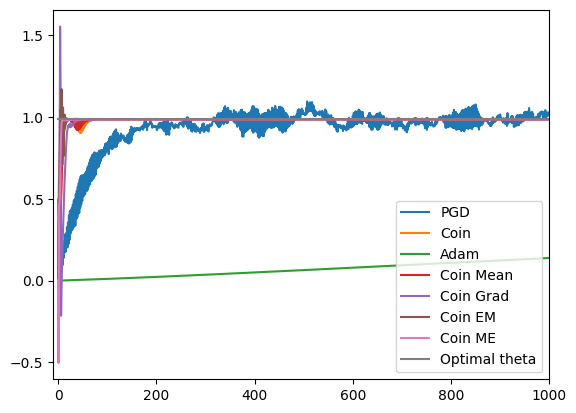

In [23]:
# Run the algorithms using the optimal step-sizes:
#th_pgd = pgd(y, 2/(2+D), K, N, th0, X0)
#th_pqn = pqn(y, 2/3, K, N, th0, X0)
#th_pmgd = pmgd(y, 1, K, N, X0)

from coinem.zoo import gradient_step_coin_svgd
K = 1000

x_pgd, th_pgd = pgd(model, X0, th0, K, 2.0/(2.0+Dy))  # Optimal step-size
x_coin, th_coin = coin_svgd(model, X0, th0, K)  # CoinEM
x_coin_em, th_coin_em = coin_svgd_em(model, X0, th0, K)  # CoinEM with EM
x_coin_me, th_coin_me = coin_svgd_me(model, X0, th0, K)  # CoinEM with ME
x_coin_mean, th_coin_mean = mean_coin_svgd(model, X0, th0, K)  # CoinEM with mean
x_adam, th_adam = adam_svgd(model, X0, th0, K, 1e-4, 1e-4)  # Adam
x_coin_grad, th_coin_grad = gradient_step_coin_svgd(model, X0, th0, K)  # CoinEM with mean

#th_coinS = coin_sampling(y, K, N, X0)
#th_em = em(y, K, th0)

# Plot parameter estimates as a function of step number k:
plt.plot(th_pgd, label='PGD')
#plt.plot(th_pqn, label='PQN')
#plt.plot(th_pmgd, label='PMGD')
plt.plot(th_coin, label='Coin')
plt.plot(th_adam, label='Adam')
plt.plot(th_coin_mean, label='Coin Mean')
plt.plot(th_coin_grad, label='Coin Grad')
plt.plot(th_coin_em, label='Coin EM')
plt.plot(th_coin_me, label='Coin ME')
#plt.plot(th_coinS, label='Coin Sampling')
#plt.plot(th_em, label='EM')
plt.plot(y.mean()*jnp.ones(K), label='Optimal theta')
plt.legend(loc='lower right')
plt.xlim([-K/100, K])

To extract converging estimates from PGD, PQN, and PMGD, we average over time (starting once the estimates reach stationarity). To this end, we use the following function that cumulatively averages all entries of a vector x past a threshold n: 

We then obtain the following:

(-10.0, 1000.0)

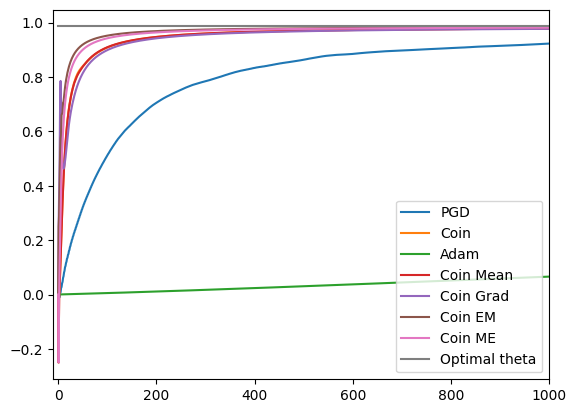

In [24]:
from coinem.utils import cum_mean as cmean

plt.plot(cmean(th_pgd), label='PGD')
#plt.plot(cmean(th_pqn), label='PQN')
#plt.plot(cmean(th_pmgd), label='PMGD')
plt.plot(cmean(th_coin), label='Coin')

plt.plot(cmean(th_adam), label='Adam')
plt.plot(cmean(th_coin_mean), label='Coin Mean')
plt.plot(cmean(th_coin_grad), label='Coin Grad')
plt.plot(cmean(th_coin_em), label='Coin EM')
plt.plot(cmean(th_coin_me), label='Coin ME')
#plt.plot(cmean(th_coinS), label='Coin Sampling')
#plt.plot(th_em, label='EM')
plt.plot(y.mean()*jnp.ones(K), label='Optimal theta')
plt.legend(loc='lower right')
plt.xlim([-K/100, K])

## Latent posterior analysis:

### MSE of the emperical distribution vs the truth:

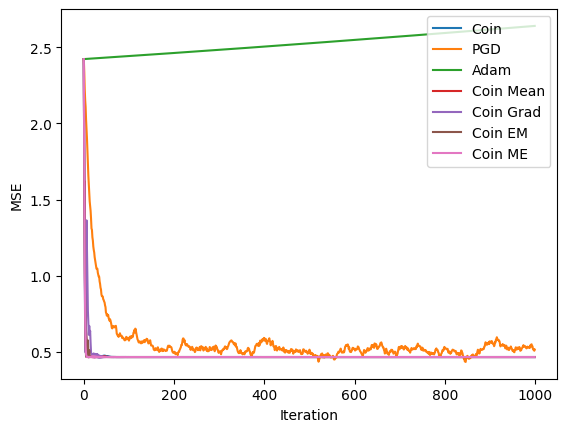

In [25]:
plt.plot(((x_coin.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin')
plt.plot(((x_pgd.mean(axis=1) - latent) ** 2).mean(axis = 1), label='PGD')
plt.plot(((x_adam.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Adam')
plt.plot(((x_coin_mean.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin Mean')
plt.plot(((x_coin_grad.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin Grad')
plt.plot(((x_coin_em.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin EM')
plt.plot(((x_coin_me.mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin ME')
plt.ylabel('MSE')
plt.xlabel('Iteration')
plt.legend(loc='upper right')

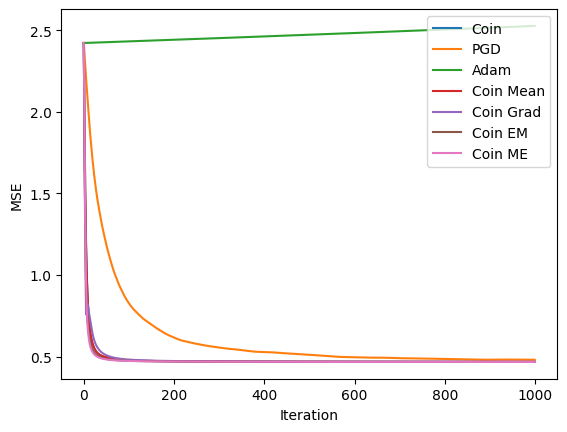

In [26]:
from coinem.utils import cum_mean as cmean

plt.plot(((cmean(x_coin).mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin')
plt.plot(((cmean(x_pgd).mean(axis=1) - latent) ** 2).mean(axis = 1), label='PGD')
plt.plot(((cmean(x_adam).mean(axis=1) - latent) ** 2).mean(axis = 1), label='Adam')
plt.plot(((cmean(x_coin_mean).mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin Mean')
plt.plot(((cmean(x_coin_grad).mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin Grad')
plt.plot(((cmean(x_coin_em).mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin EM')
plt.plot(((cmean(x_coin_me).mean(axis=1) - latent) ** 2).mean(axis = 1), label='Coin ME')
plt.ylabel('MSE')
plt.xlabel('Iteration')
plt.legend(loc='upper right')